## Deep MMD - GAN with MNIST dataset


In [1]:
%matplotlib inline

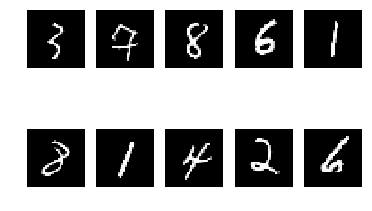

In [2]:
from matplotlib import pyplot as plt
import numpy

from nn_class import GeneratorNet, DiscriminatorNet

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms

class options:
    cuda = True
    batch_size = 256
    image_size = 32
    n_filters = 100

transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets/MNIST/',
                   transform=transform, download=True),
    batch_size=256, shuffle=True,
)

for x, _ in dataloader:
    for i in range(2 * 5):
        plt.subplot(2, 5, i + 1)
        plt.axis('off')
        plt.imshow(x.numpy()[i, 0], vmin=0, vmax=1, cmap='gray')
    break

0 0 235 17.801658630371094


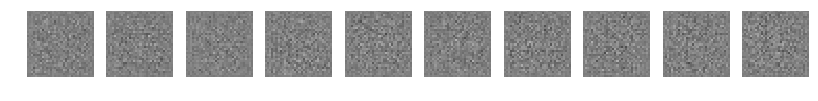

1 0 235 30.70780372619629


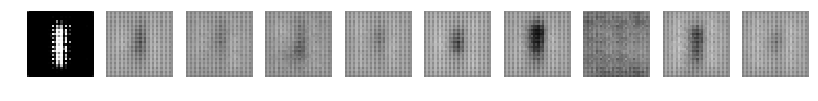

2 0 235 31.378753662109375


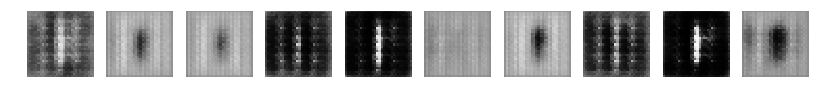

3 0 235 29.58673858642578


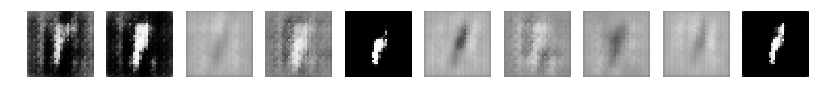

4 0 235 27.78803253173828


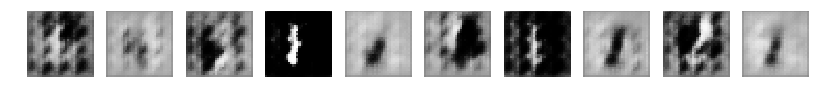

5 0 235 24.23335838317871


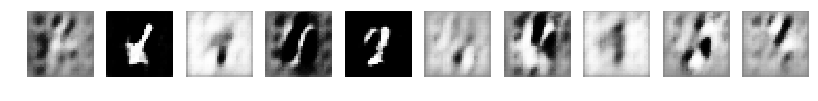

6 0 235 18.74859619140625


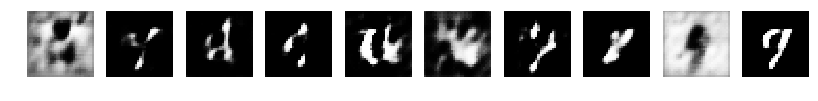

7 0 235 22.45068359375


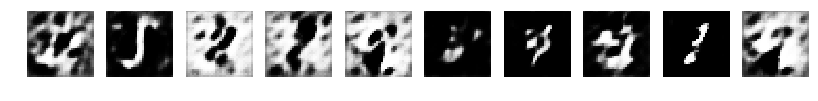

8 0 235 24.129230499267578


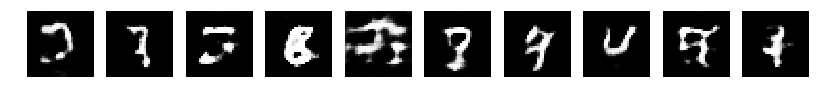

9 0 235 24.164567947387695


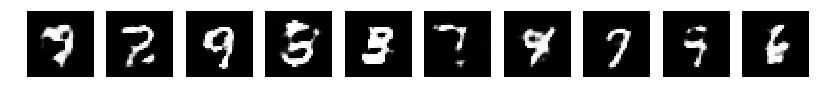

10 0 235 23.30282974243164


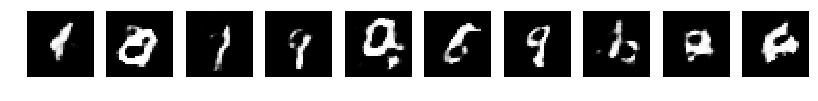

11 0 235 24.24880027770996


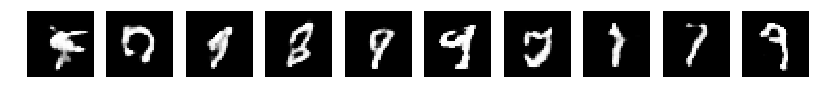

12 0 235 23.73977279663086


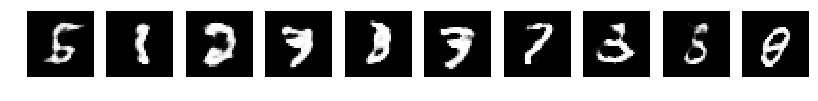

13 0 235 23.851957321166992


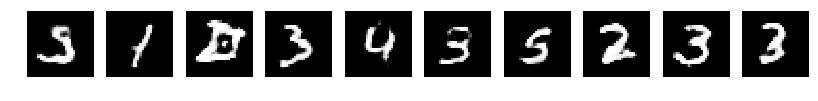

14 0 235 24.65802764892578


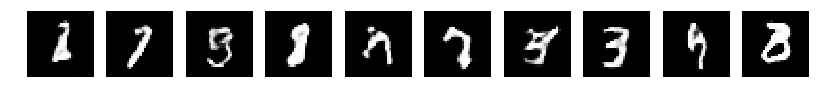

15 0 235 21.540733337402344


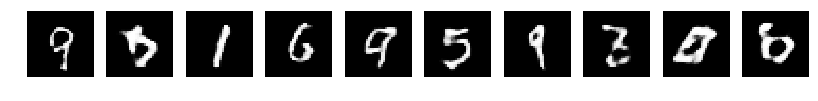

16 0 235 23.69546890258789


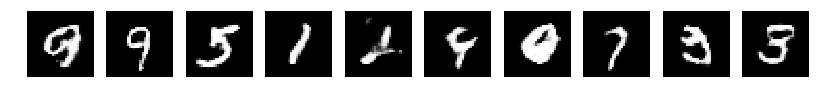

17 0 235 21.979034423828125


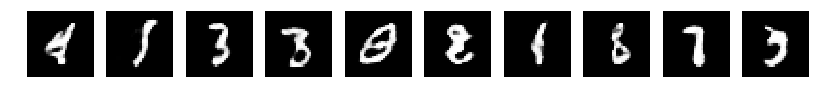

18 0 235 23.486284255981445


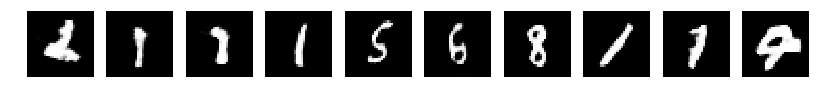

19 0 235 22.691316604614258


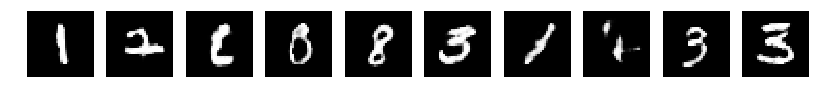

20 0 235 24.08408546447754


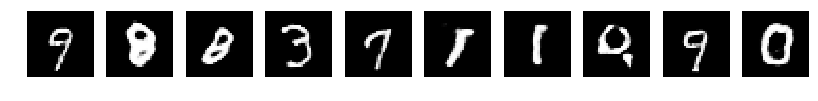

21 0 235 23.0516300201416


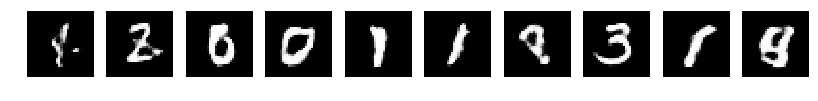

22 0 235 22.495513916015625


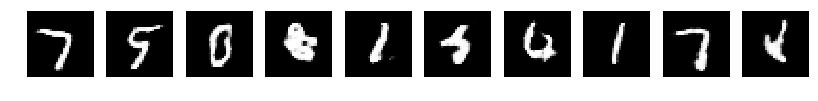

23 0 235 23.899614334106445


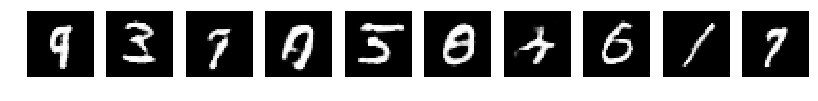

24 0 235 22.772724151611328


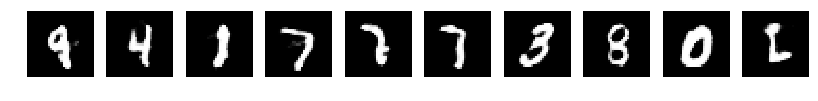

25 0 235 23.761425018310547


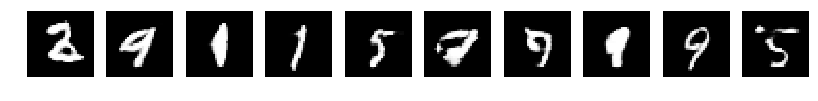

26 0 235 23.01340103149414


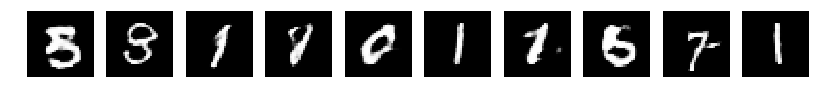

27 0 235 23.192323684692383


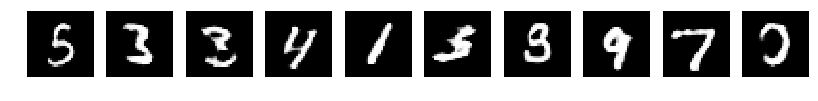

28 0 235 22.598108291625977


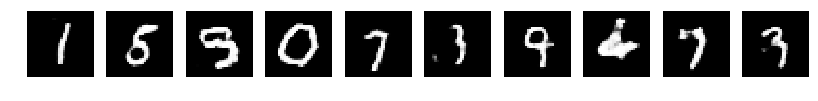

29 0 235 23.250141143798828


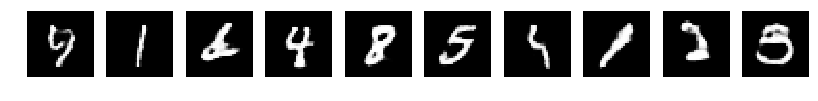

30 0 235 22.62422752380371


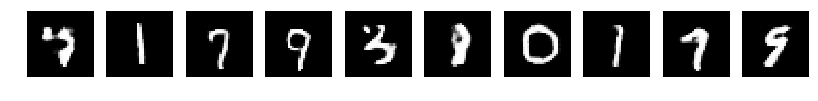

31 0 235 23.953582763671875


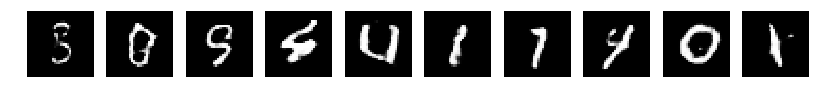

32 0 235 22.936187744140625


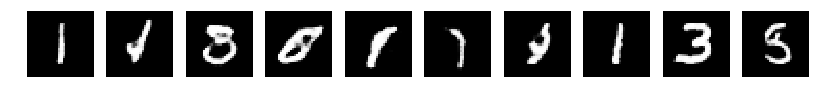

33 0 235 23.879375457763672


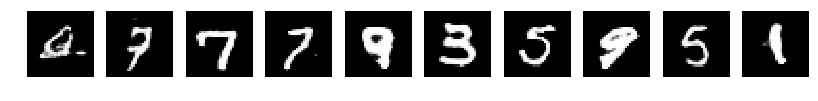

34 0 235 23.105567932128906


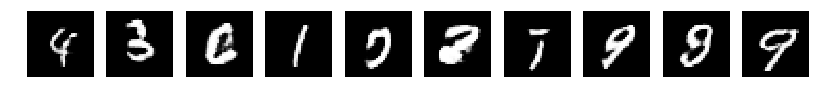

35 0 235 24.60382652282715


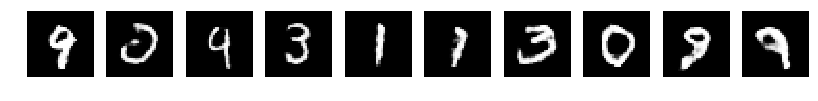

36 0 235 24.141408920288086


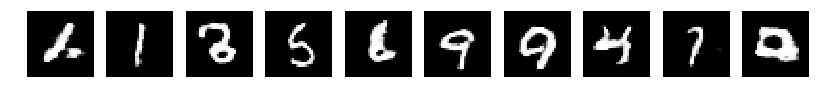

37 0 235 23.077489852905273


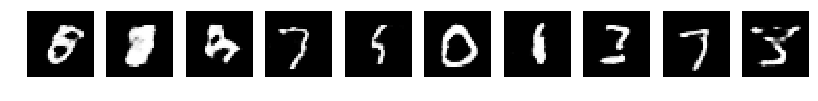

38 0 235 24.462181091308594


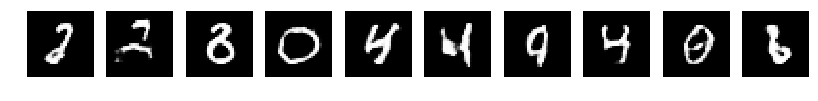

39 0 235 23.580623626708984


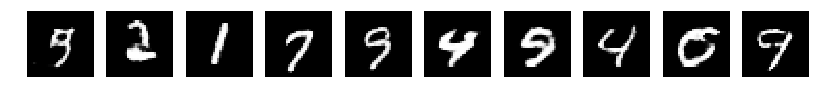

40 0 235 23.11257553100586


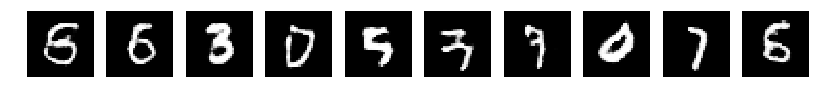

41 0 235 23.828954696655273


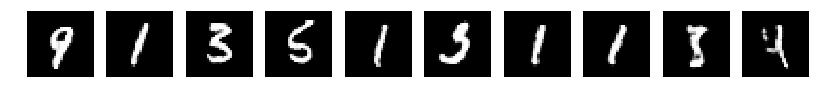

42 0 235 22.39179039001465


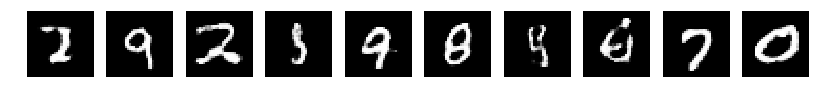

43 0 235 21.048341751098633


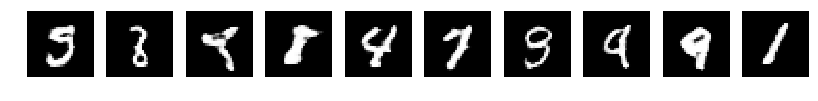

44 0 235 21.24532127380371


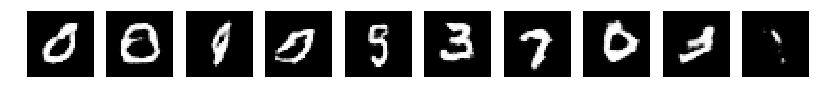

45 0 235 22.414831161499023


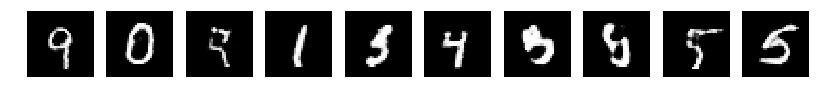

46 0 235 24.645626068115234


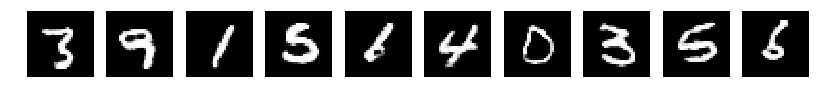

47 0 235 24.064167022705078


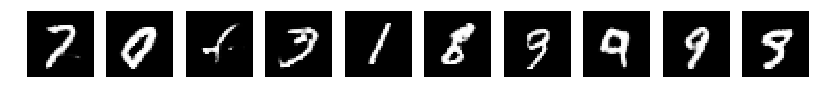

48 0 235 25.244604110717773


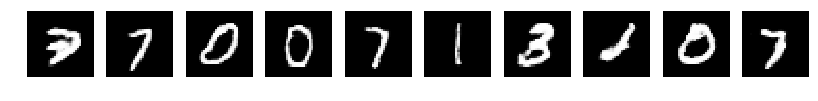

49 0 235 23.33917236328125


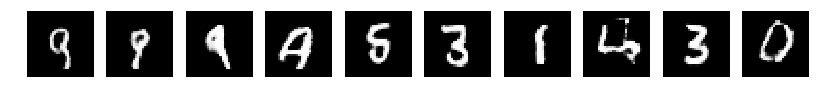

In [3]:
netG = GeneratorNet(input_nfilters=100, generator_nfilters=64, image_size=32, n_colors=1)
netD = DiscriminatorNet(discriminator_nfilters=32, image_size=32, n_colors=1)

criterion = nn.BCELoss()

noise = torch.FloatTensor(options.batch_size, options.n_filters, 1, 1)

if options.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    noise = noise.cuda()

# setup optimizer.
# Yup, just added minus to learning rate - and that's where you get adeversarial training :)
optimizerD = optim.Adam(netD.parameters(), lr=-1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=+1e-4, betas=(0.5, 0.999))

for epoch in range(50):
    for i, (real_cpu, _) in enumerate(dataloader):
        netD.zero_grad()
        netG.zero_grad()

        # get real batch
        if options.cuda:
            real_cpu = real_cpu.cuda()
        real = Variable(real_cpu)

        # generate fake
        noise.normal_(0, 1)
        fake = netG(Variable(noise))

        # joint to have common batch-norm transform
        outputs = netD(torch.cat([real, fake], dim=0))
        output_real = outputs[:real.size(0)]
        output_fake = outputs[real.size(0):]

        MMD = torch.norm(output_fake.mean(dim=0) - output_real.mean(dim=0))
        MMD.backward()

        optimizerD.step()
        optimizerG.step()

        if i == 0:
            print(epoch, i, len(dataloader), MMD.data[0])

            plt.figure(figsize=[14, 5])
            n_images = 10
            for image_id in range(n_images):
                plt.subplot(1, n_images, image_id + 1)
                plt.axis('off')
                plt.imshow(fake.data.cpu().numpy()[image_id, 0, :, :] * 0.5 + 0.5, cmap='gray', vmin=0, vmax=1)
            plt.show()